# IMPORT LIBRARY AND DATASET

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.ticker import FuncFormatter
import math

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

import warnings
warnings.filterwarnings('ignore')

def print_data_info(df):
    dataDesc=[]
    for i in df.columns:
        unique_values = df[i].drop_duplicates()
        sample_count = min(2, len(unique_values))  # Only sample as many as available (max 2)
        samples = unique_values.sample(sample_count).values
        dataDesc.append([
            i,
            df[i].dtypes,
            df[i].isna().sum(),
            round((((df[i].isna().sum())/len(df))*100), 2),
            df[i].nunique(),
            samples
        ])


    data_info = pd.DataFrame(dataDesc, columns=[
        'Data Features',
        'Data Types',
        'Null',
        'Null Percentage',
        'Unique',
        'Unique Sample'
    ])

    # Display Info
    print(f'Rows: {df.shape[0]:,}, Column: {df.shape[1]:,}')
    print('-' * 80)
    display(data_info)

In [13]:
df = pd.read_csv('credit_scoring.csv')
df

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,leak_col_good,leak_col_subtle
0,501000,41,13995609,5982664,0,624,0,0,-0.040
1,501001,58,13683833,3711198,0,809,0,0,0.001
2,501002,33,9417391,7172332,0,647,0,0,0.077
3,501003,45,6861811,8661056,0,450,0,0,0.038
4,501004,22,5640742,4520669,1,816,0,0,0.020
...,...,...,...,...,...,...,...,...,...
5995,506995,26,18253018,3690565,2,729,0,0,0.008
5996,506996,40,9944385,4082038,1,477,0,0,0.017
5997,506997,28,9048532,14760384,0,450,0,0,-0.054
5998,506998,51,6843160,11774594,0,561,0,0,0.026


In [15]:
print_data_info(df)

Rows: 6,000, Column: 9
--------------------------------------------------------------------------------


,Data Features,Data Types,Null,Null Percentage,Unique,Unique Sample
0,application_id,int64,0,0.0,6000,"[502468, 504244]"
1,age,int64,0,0.0,39,"[48, 22]"
2,monthly_income,int64,0,0.0,6000,"[9933911, 8007808]"
3,loan_amount,int64,0,0.0,6000,"[6108715, 2861985]"
4,previous_defaults,int64,0,0.0,4,"[1, 0]"
5,credit_score,int64,0,0.0,550,"[596, 365]"
6,default,int64,0,0.0,2,"[1, 0]"
7,leak_col_good,int64,0,0.0,2,"[1, 0]"
8,leak_col_subtle,float64,0,0.0,239,"[-0.016, 0.999]"


# DATA PREPARATION

In [17]:
df_clean = df.copy()

**DROP FITUR LEAKAGE**

In [19]:
df_clean.drop(columns = ['leak_col_good', 'leak_col_subtle'], inplace=True)
df_clean

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default
0,501000,41,13995609,5982664,0,624,0
1,501001,58,13683833,3711198,0,809,0
2,501002,33,9417391,7172332,0,647,0
3,501003,45,6861811,8661056,0,450,0
4,501004,22,5640742,4520669,1,816,0
...,...,...,...,...,...,...,...
5995,506995,26,18253018,3690565,2,729,0
5996,506996,40,9944385,4082038,1,477,0
5997,506997,28,9048532,14760384,0,450,0
5998,506998,51,6843160,11774594,0,561,0


In [21]:
df_clean.describe(include='number')

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default
count,6000.000000,6000.000000,6.000000e+03,6.000000e+03,6000.000000,6000.000000,6000.000000
mean,503999.500000,40.321500,1.140386e+07,8.001122e+06,0.243667,575.979833,0.012167
std,1732.195139,11.300697,4.912598e+06,4.071786e+06,0.484767,158.328931,0.109639
min,501000.000000,21.000000,3.000310e+06,1.000794e+06,0.000000,300.000000,0.000000
25%,502499.750000,31.000000,7.163379e+06,4.440939e+06,0.000000,438.750000,0.000000
50%,503999.500000,41.000000,1.129945e+07,7.982304e+06,0.000000,577.500000,0.000000
75%,505499.250000,50.000000,1.573705e+07,1.153144e+07,0.000000,713.000000,0.000000
max,506999.000000,59.000000,1.998622e+07,1.499858e+07,3.000000,849.000000,1.000000


**DUPLICATED DATA**

In [23]:
print('Number of duplicate records found:', df_clean.duplicated().sum())

Number of duplicate records found: 0


**OUTLIER CHECKING AND DATA DISTRIBUTION**

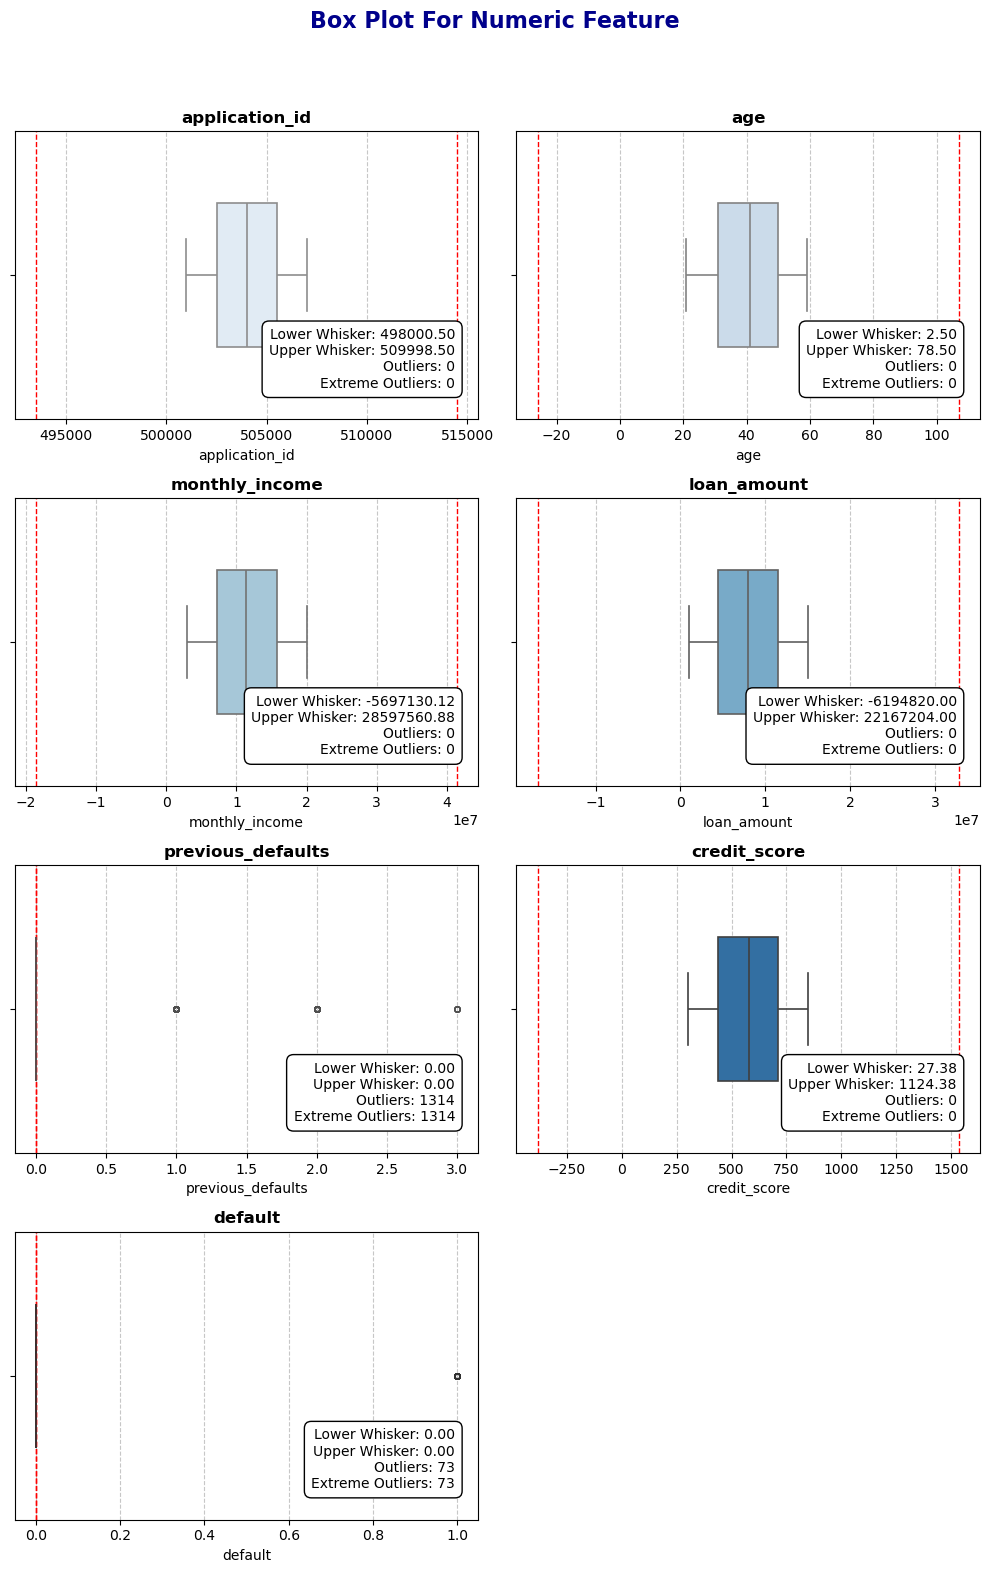

In [25]:
features = df_clean.select_dtypes(include='number').columns
rows = (len(features) // 2) + (len(features) % 2)
cols = 2

plt.figure(figsize=(cols * 5, rows * 4))
plt.suptitle('Box Plot For Numeric Feature', fontsize=16, fontweight='bold', color='darkblue')

colors = sns.color_palette("Blues", len(features))

for idx, column in enumerate(features):
    ax = plt.subplot(rows, cols, idx + 1)
    sns.boxplot(x=df_clean[column], color=colors[idx], width=0.5, fliersize=4, linewidth=1.2)
    plt.title(column, fontsize=12, fontweight='bold')
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    q1 = df_clean[column].quantile(0.25)
    q3 = df_clean[column].quantile(0.75)
    iqr = q3 - q1
    lower_whisker = q1 - (1.5 * iqr)
    upper_whisker = q3 + (1.5 * iqr)
    extreme_lower_whisker = q1 -( 3 * iqr)
    extreme_upper_whisker = q3 + ( 3 * iqr)
    outliers = df_clean[(df_clean[column] < lower_whisker) | (df_clean[column] > upper_whisker)][column]
    extreme_outliers = df_clean[(df_clean[column] < extreme_lower_whisker) | (df_clean[column] > extreme_upper_whisker)][column]
    
    ax.axvline(extreme_lower_whisker, color='red', linestyle='--', linewidth=1)
    ax.axvline(extreme_upper_whisker, color='red', linestyle='--', linewidth=1)

    info_text = f"Lower Whisker: {lower_whisker:.2f}\nUpper Whisker: {upper_whisker:.2f}\nOutliers: {len(outliers)}\nExtreme Outliers: {len(extreme_outliers)}"
    plt.text(0.95, 0.1, info_text, transform=ax.transAxes, fontsize=10,
             verticalalignment='bottom', horizontalalignment='right',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Berdasarkan box plot, fitur-fitur yang ada tidak memiliki outlier dan terdistribusi normal. Standard Scaler atau Robust Scaler dapat digunakan pada proses modelling. Histogram dan uji statistik akan digunakan untuk pengecekan lebih lanjut mengenai distribusi data.

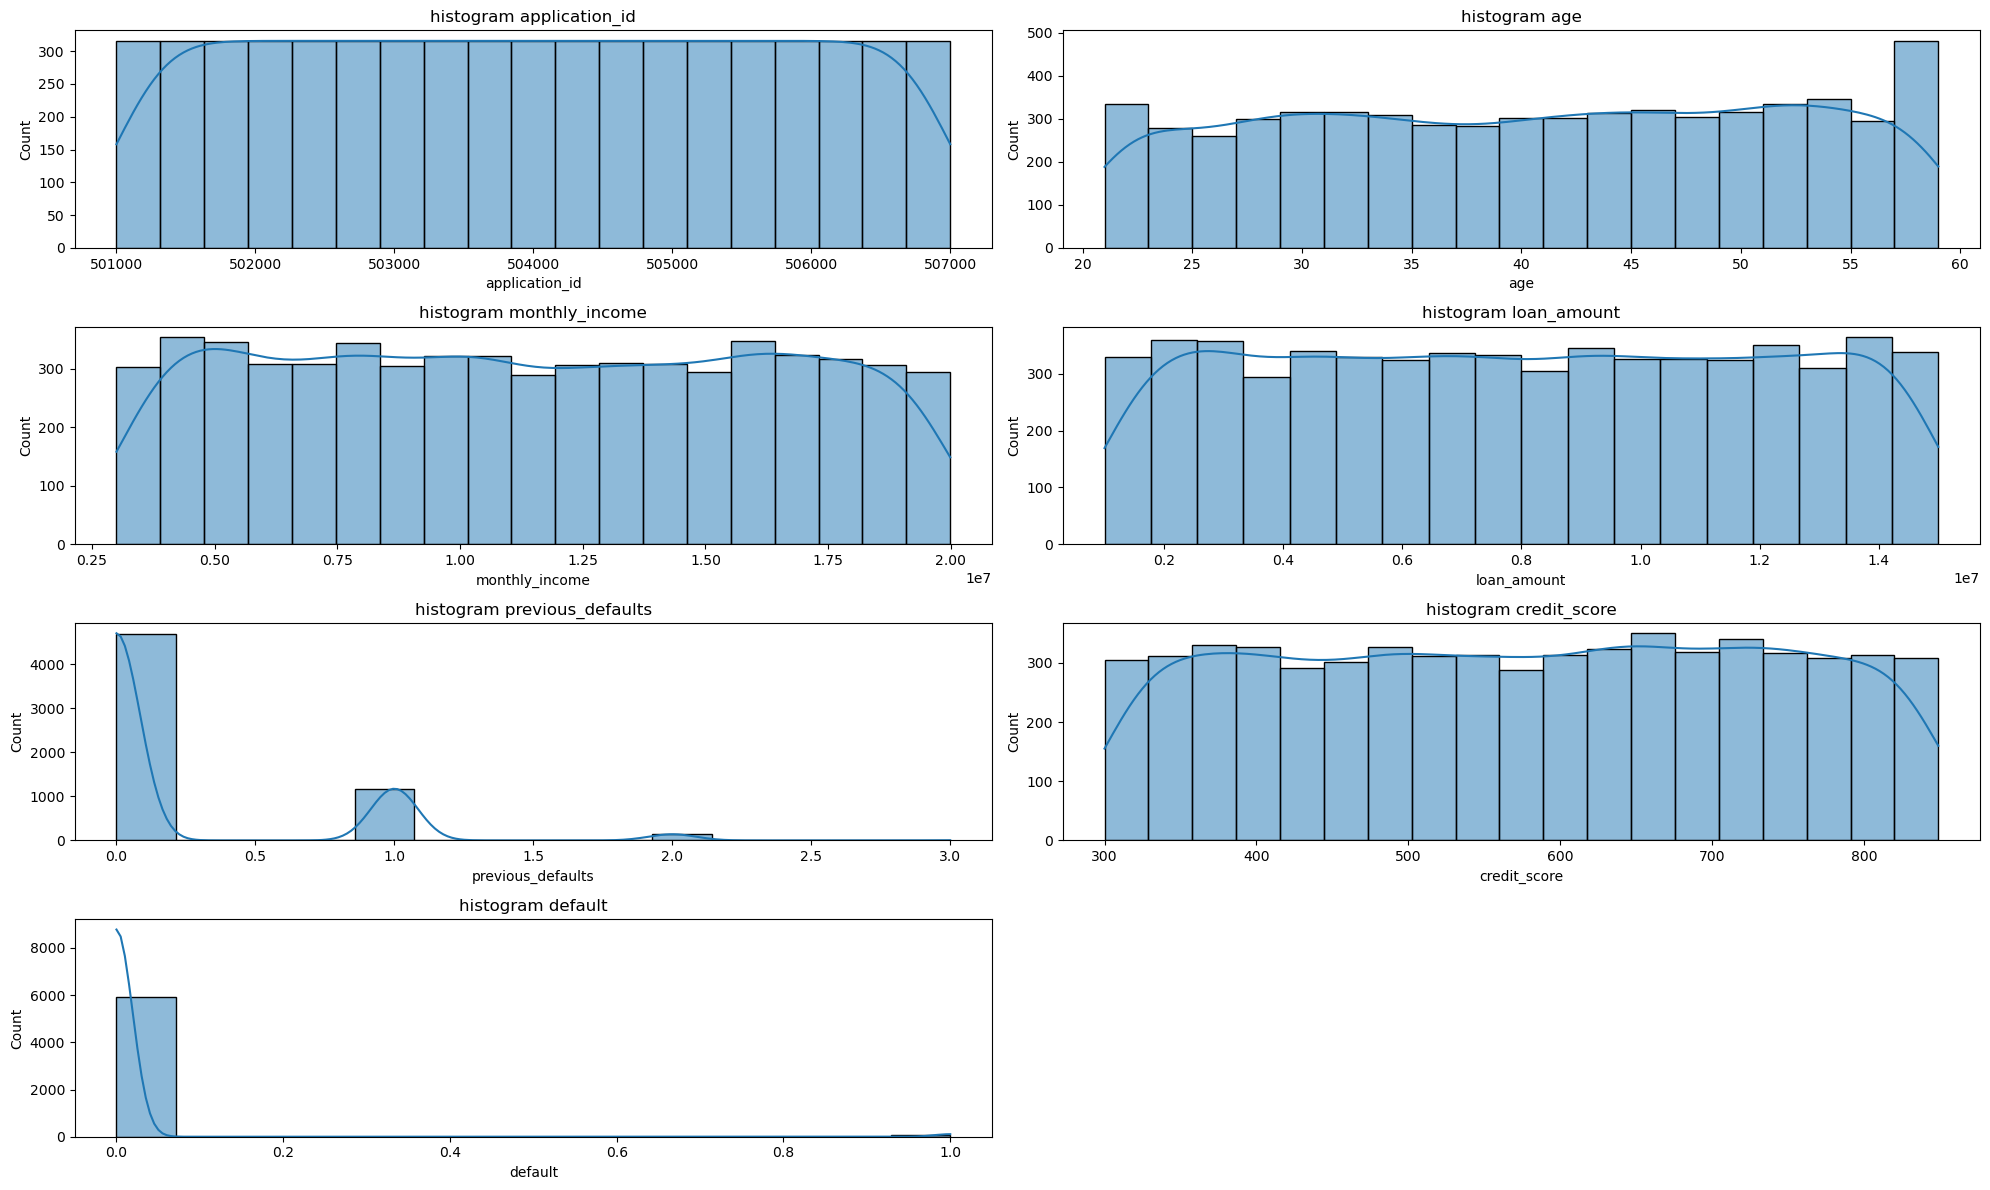

In [29]:
sum = len(df_clean.select_dtypes(include='number').columns)
row = math.ceil(sum / 2)  # misalnya 2 kolom per baris

fig = plt.figure(figsize=(20,row *3)) # horizontal, vertikal

count = 0
for kolom in df_clean.select_dtypes(include='number').columns:
    count += 1
    plt.subplot(row,2,count)
    sns.histplot(df_clean.select_dtypes(include='number')[kolom], kde=True)
    plt.title(f"histogram {kolom}")
    fig.tight_layout() # biar tidak tertumpuk
plt.show()

In [31]:
from scipy.stats import normaltest

for col in df_clean.select_dtypes(include='number').columns:
    stat, p_value = normaltest(df_clean[col])
    print(f"Kolom '{col}':")
    print("p-value =", p_value)

    # Interpretasi hasil tes
    alpha = 0.05
    if p_value > alpha:
         print("Data is normally distributed (fail to reject H0)")
    else:
         print("Data is not normally distributed (reject H0)")
    print()

Kolom 'application_id':
p-value = 0.0
Data is not normally distributed (reject H0)

Kolom 'age':
p-value = 0.0
Data is not normally distributed (reject H0)

Kolom 'monthly_income':
p-value = 0.0
Data is not normally distributed (reject H0)

Kolom 'loan_amount':
p-value = 0.0
Data is not normally distributed (reject H0)

Kolom 'previous_defaults':
p-value = 0.0
Data is not normally distributed (reject H0)

Kolom 'credit_score':
p-value = 0.0
Data is not normally distributed (reject H0)

Kolom 'default':
p-value = 0.0
Data is not normally distributed (reject H0)



**ANOMALIES CHECKING**

**CLEANED DATA**

In [45]:
df_clean.drop(columns = 'application_id', inplace=True)

In [47]:
df_clean

,age,monthly_income,loan_amount,previous_defaults,credit_score,default
0,41,13995609,5982664,0,624,0
1,58,13683833,3711198,0,809,0
2,33,9417391,7172332,0,647,0
3,45,6861811,8661056,0,450,0
4,22,5640742,4520669,1,816,0
...,...,...,...,...,...,...
5995,26,18253018,3690565,2,729,0
5996,40,9944385,4082038,1,477,0
5997,28,9048532,14760384,0,450,0
5998,51,6843160,11774594,0,561,0


# DATA ANALYSIS

**Jumlah Application yang Default**

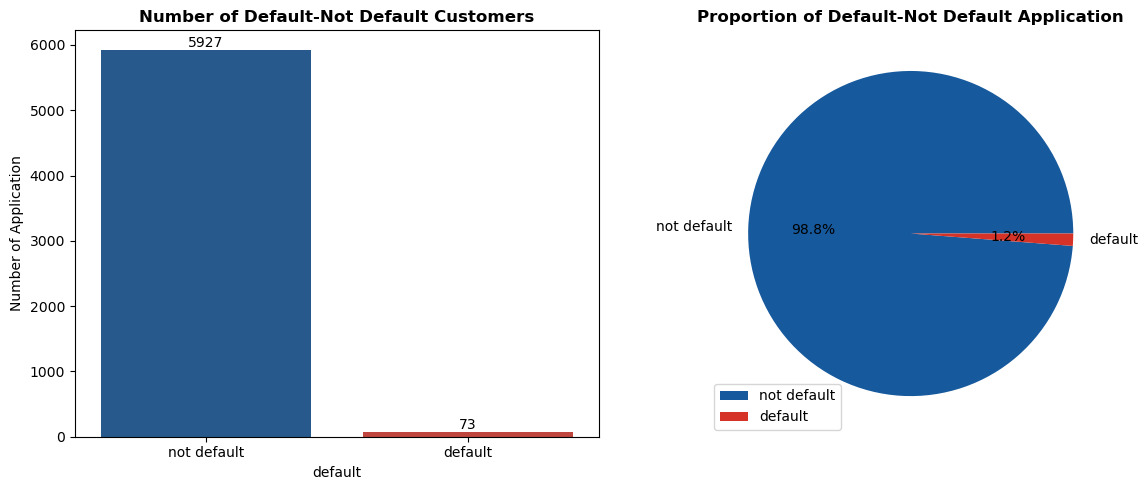

In [50]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title('Number of Default-Not Default Customers', fontweight='bold')
cntplot = sns.countplot(x=df_clean['default'], hue=df_clean['default'], palette=['#16599d', '#d53328'], legend=False)
for p in cntplot.patches:
    if p.get_height() > 1:
        cntplot.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.xticks(ticks=[0,1], labels=['not default', 'default'])
plt.ylabel('Number of Application')

plt.subplot(1,2,2)
plt.title('Proportion of Default-Not Default Application', fontweight='bold')
plt.pie(x=df_clean['default'].value_counts(), labels=df_clean['default'].value_counts().reset_index()['default'].map({0:'not default', 1:'default'}), autopct='%.1f%%', colors=['#16599d', '#d53328'])
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

**HUBUNGAN FITUR DENGAN DEFAULT**

In [55]:
df_clean.columns

Index(['age', 'monthly_income', 'loan_amount', 'previous_defaults',
       'credit_score', 'default'],
      dtype='object')

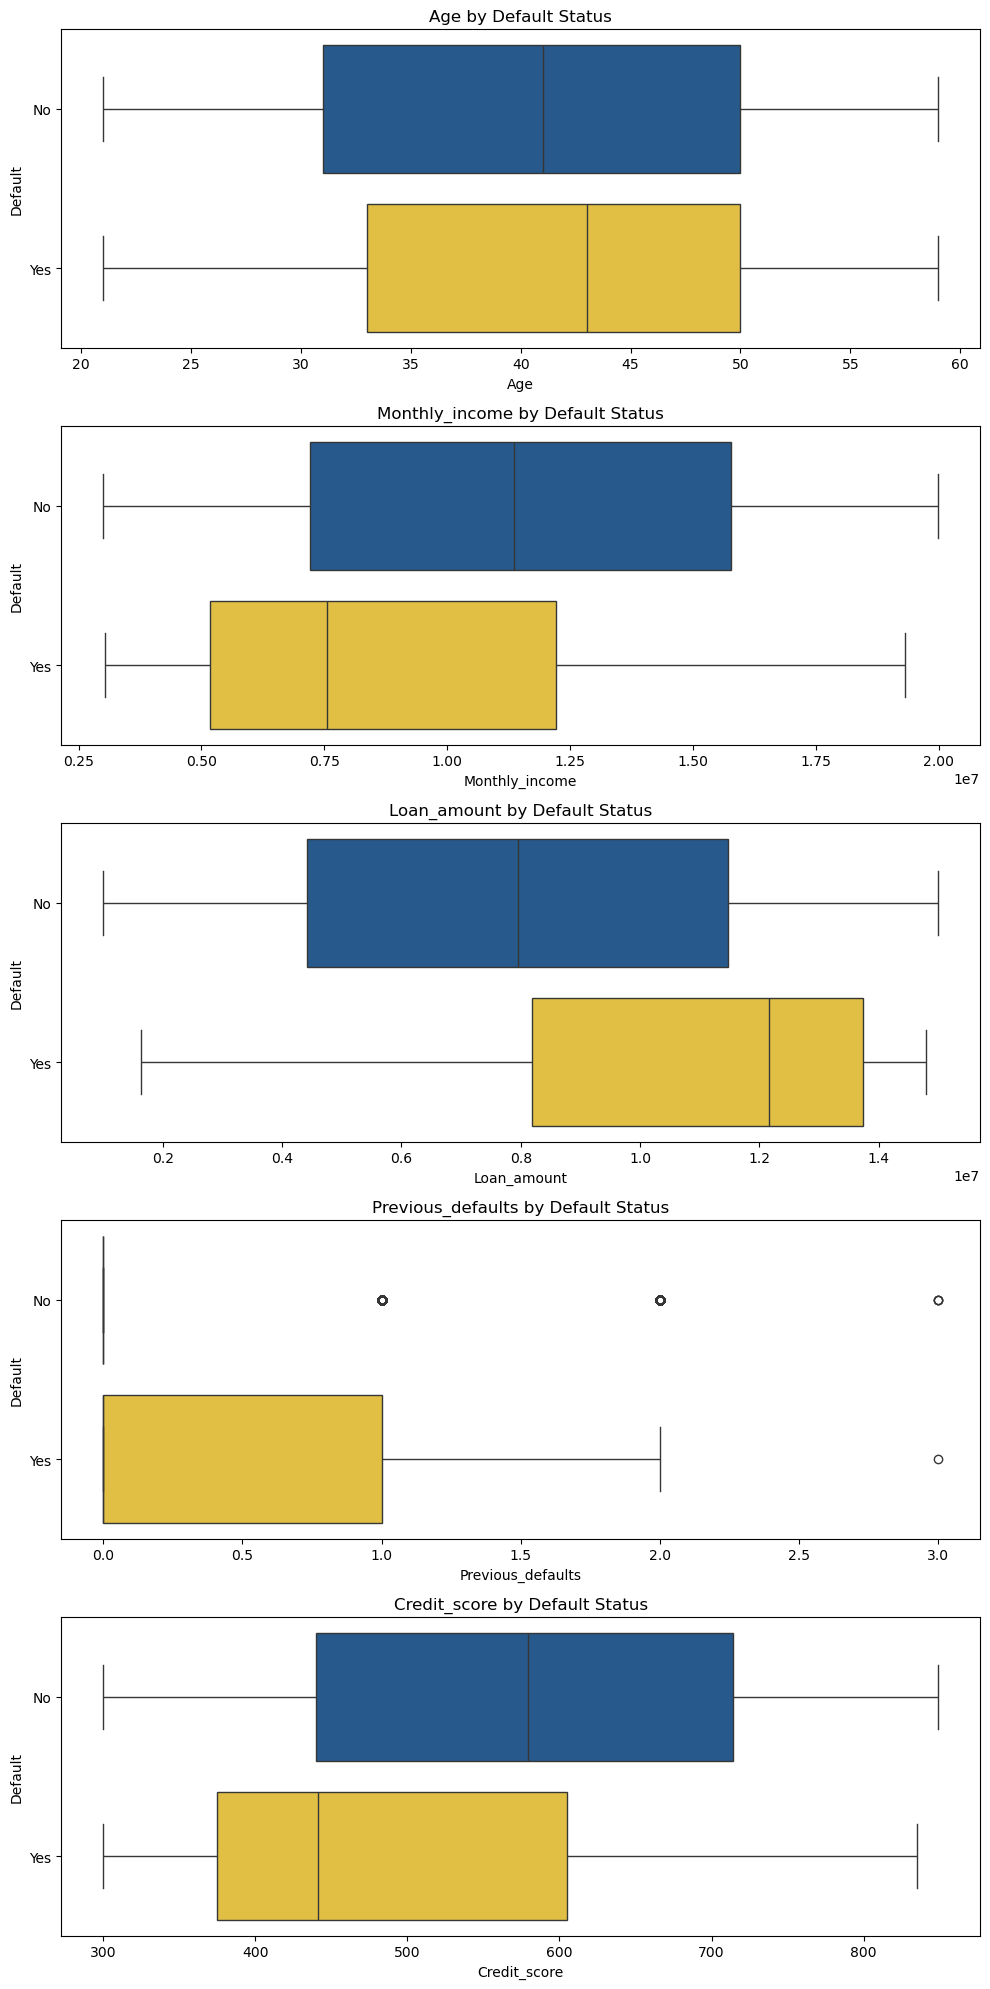

In [80]:
feature_cols = ['age', 'monthly_income', 'loan_amount', 'previous_defaults', 'credit_score']

plt.figure(figsize=(10, 4 * len(feature_cols)))

for idx, col in enumerate(feature_cols):
    plt.subplot(len(feature_cols), 1, idx + 1)
    sns.boxplot(data=df_clean, y='default', x=col, palette=['#16599d', '#fbcd2b'], orient='h')
    plt.title(f'{col.capitalize()} by Default Status')
    plt.ylabel('Default')
    plt.xlabel(col.capitalize())
    plt.yticks([0, 1], ['No', 'Yes'])

plt.tight_layout()
plt.show()


Berdasarkan Visualisasi Box Plot:
- Applicant yang default mayoritas memiliki umur diantara 33 Tahun - 50 tahun, lebih tinggi dari umur non-default applicant.
- Non-default applicant umumnya memiliki monthly income diantara 7000000 - 16000000, lebih tinggi dari default applicant (5000000 - 12000000).
- Default application memiliki loan amount yang lebih tinggi dibandingkan non-default application, yakni mayoritas pinjaman sebesar 8000000 - 14000000
- Default application memiliki credit score yang lebih rendah dari non-default, dengan default application mayoritas memiliki skor 380 s.d. 600.

Fitur loan amount dan credit score dapat menjadi fitur yang baik dalam pembuatan model.